In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import torch.optim as optim

from copy import deepcopy

from torch.distributions import Categorical

import itertools

import sys
sys.path.insert(0, './../libraries/')

import partial_marginalization_lib as pm_lib
import gmm_experiments_lib as gmm_lib

In [2]:
softmax = nn.Softmax(dim = 0)

sigmoid = nn.Sigmoid()

In [3]:
import torch

In [4]:
np.random.seed(4524)
_ = torch.manual_seed(4524)

We are interested in minimizing an objective of the form 
\begin{align}
E_{q_\eta(z)}[f(z)]
\end{align}
where $z$ is a discrete random variable, so the re-parametrization trick does not apply. 

We consider a simple experiment, and examine the performance of REINFORCE, ARM, and a new proposed method. 


In [5]:
mu0 = torch.Tensor([0, 0])
sigma0 = 10.
n_clusters = 5

n_obs = 3

In [6]:
gmm_experiment = gmm_lib.GMMExperiments(n_obs, mu0, sigma0, n_clusters)

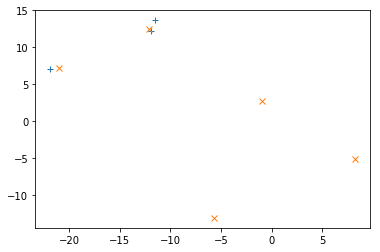

In [7]:
plt.plot(gmm_experiment.y[:, 0].numpy(), gmm_experiment.y[:, 1].numpy(), '+')
plt.plot(gmm_experiment.true_mus[:, 0].numpy(), gmm_experiment.true_mus[:, 1].numpy(), 'x')

In [8]:
obj_class_reinforce = pm_lib.PartialMarginalizationREINFORCE(gmm_experiment)

In [9]:
obj_class_reinforce.get_partial_marginal_loss(alpha = 0.0, topk = 3)

(tensor([-2572.5852]), tensor(1521.2295))

In [10]:
obj_class_reinforce.run_SGD(alpha = 0.0, topk = n_clusters)

RuntimeError: invalid argument 2: invalid multinomial distribution (encountering probability entry < 0) at /opt/conda/conda-bld/pytorch-cpu_1524582300956/work/aten/src/TH/generic/THTensorRandom.cpp:326

In [10]:
gmm_experiment.var_params

{'encoder_params': <generator object Module.parameters at 0x7fac26d18d00>,
 'centroids': tensor([[  8.7002,  -4.0803],
         [  4.0153,   7.9091],
         [-11.9246,   3.5689],
         [ -7.1859,  -6.6152],
         [-16.9536,   9.4915]]),
 'sigma': tensor([ 0.7465])}

In [11]:
for key in gmm_experiment.var_params: 
    print(gmm_experiment.var_params[key])

<generator object Module.parameters at 0x7fac26d18d00>
tensor([[  8.7002,  -4.0803],
        [  4.0153,   7.9091],
        [-11.9246,   3.5689],
        [ -7.1859,  -6.6152],
        [-16.9536,   9.4915]])
tensor([ 0.7465])


In [12]:
params = [{'params': gmm_experiment.var_params[key]} for key in gmm_experiment.var_params]

In [13]:
optimizer = optim.SGD(params, lr = 0.2)